In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
%%time
# loading a dataset from previously zipped csv's
l_usecols = [u'tpep_pickup_datetime', u'tpep_dropoff_datetime',
       u'passenger_count', u'trip_distance', u'pickup_longitude', u'pickup_latitude']
l_parse_dates = [u'tpep_pickup_datetime', u'tpep_dropoff_datetime']
l_dtype = {u'passenger_count':np.int8,
           u'trip_distance':np.float32, u'pickup_longitude':np.float64, u'pickup_latitude':np.float64}
df = pd.read_csv('zip/yellow_tripdata_2016-05.csv.zip', compression = 'zip',
                 usecols = l_usecols,
                 dtype = l_dtype,
                 parse_dates = l_parse_dates,
                 infer_datetime_format = True
                )

CPU times: user 37 s, sys: 1.42 s, total: 38.4 s
Wall time: 38.8 s


In [3]:
#let's take a look
df.head(15)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude
0,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040
1,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751
2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573
3,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601
4,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192
5,2016-05-01 00:00:00,2016-05-01 00:05:19,2,0.63,-73.979294,40.755764
6,2016-05-01 00:00:00,2016-05-01 00:15:43,1,6.68,-73.981544,40.780739
7,2016-05-01 00:00:00,2016-05-01 00:06:31,1,1.48,-73.987198,40.750507
8,2016-05-01 00:00:00,2016-05-01 00:00:00,4,1.59,-74.001610,40.740990
9,2016-05-01 00:00:00,2016-05-01 00:00:00,3,3.52,-74.013855,40.714119


In [4]:
# check memory usage
print(df.memory_usage(deep = True))
print(np.sum(df.memory_usage() / 1024 / 1024))

Index                          80
tpep_pickup_datetime     94694824
tpep_dropoff_datetime    94694824
passenger_count          11836853
trip_distance            47347412
pickup_longitude         94694824
pickup_latitude          94694824
dtype: int64
417.6746759414673


In [5]:
# load regions csv
reg = pd.read_csv('regions.csv', sep = ';')

In [6]:
reg.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


In [7]:
#calculating min and max coordinates for regions and distance between the cells in the region grid
lon_min = reg.west.min()
lon_max = reg.east.max()
lon_div = (lon_max - lon_min) / (50.)

lat_min = reg.south.min()
lat_max = reg.north.max()
lat_div = (lat_max - lat_min) / (50.)
print(lat_min, lat_div, lon_min, lon_div)

40.49612 0.008388199999999983 -74.25559 0.011111600000000124


In [8]:
# filtering data
#Проведите фильтрацию: удалите поездки с
#нулевой длительностью
#нулевым количеством пассажиров
#нулевым расстоянием поездки по счётчику
#координатами начала, не попадающими в прямоугольник Нью-Йорка
print(df.shape[0])
df = df[(df.passenger_count > 0) &
        (df.trip_distance > 0.) &
        (df.tpep_dropoff_datetime > df.tpep_pickup_datetime) &
        (df.pickup_longitude.between(lon_min, lon_max)) &
        (df.pickup_latitude.between(lat_min, lat_max))]
print(df.shape[0])
# flooring pickup datetime to hours for foloowing grouping
df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime).dt.floor('1H')

11836853
11626521


In [9]:
# check math with regions
reg['calc_region'] = ((reg.south - lat_min) / lat_div + \
                       (reg.west - lon_min) / lon_div * 50 + 1.1).map(int)
# +1.1 for better float flooring

In [10]:
# have a look on calculated regions and loaded
reg.head(20)

,region,west,east,south,north,calc_region
0,1,-74.25559,-74.244478,40.496120,40.504508,1
1,2,-74.25559,-74.244478,40.504508,40.512896,2
2,3,-74.25559,-74.244478,40.512896,40.521285,3
3,4,-74.25559,-74.244478,40.521285,40.529673,4
4,5,-74.25559,-74.244478,40.529673,40.538061,5
5,6,-74.25559,-74.244478,40.538061,40.546449,6
6,7,-74.25559,-74.244478,40.546449,40.554837,7
7,8,-74.25559,-74.244478,40.554837,40.563226,8
8,9,-74.25559,-74.244478,40.563226,40.571614,9
9,10,-74.25559,-74.244478,40.571614,40.580002,10


In [11]:
# checking for errors in the whole dataset
#Не забудьте проверить, что идентификаторы, которые вы присваиваете ячейкам, соответствуют приложенному выше файлу.
reg[reg.region != reg.calc_region].shape[0]

0

In [12]:
# applying region calculations to the main dataset
df['pickup_region'] = ((df.pickup_latitude - lat_min) // lat_div + \
                       (df.pickup_longitude - lon_min) // lon_div * 50 + 1.1).map(int)


In [13]:
# looking on regions data.
# if you take a look on a map, you will find what we have water cells, of course noone can take a cab there
print(df.pickup_region.describe())

count    1.162652e+07
mean     1.277297e+03
std      1.754813e+02
min      1.500000e+01
25%      1.181000e+03
50%      1.232000e+03
75%      1.287000e+03
max      2.487000e+03
Name: pickup_region, dtype: float64


In [14]:
# dropping unnecessary data
df.drop(['tpep_dropoff_datetime', 'passenger_count', 'passenger_count',
         'pickup_latitude', 'pickup_longitude',
         'trip_distance'
        ], axis = 1, inplace = True)

In [15]:
# checking memory usage
print(df.memory_usage(deep = True) )
print(np.sum(df.memory_usage() / 1024 / 1024) )

Index                   93012168
tpep_pickup_datetime    93012168
pickup_region           93012168
dtype: int64
266.10994720458984


In [16]:
df.head()

,tpep_pickup_datetime,pickup_region
0,2016-05-01,1233
1,2016-05-01,1180
2,2016-05-01,1180
3,2016-05-01,1173
4,2016-05-01,1130


In [17]:
# adding new column for grouping 
df['trips'] = 0

In [18]:
# grouping data by time and region
df_grp = df.groupby([df.tpep_pickup_datetime, df.pickup_region]).count()
df_grp = df_grp.add_suffix('_count').reset_index()

In [19]:
df_grp.head()

,tpep_pickup_datetime,pickup_region,tpep_pickup_datetime_count,pickup_region_count,trips_count
0,2016-05-01,1015,1,1,1
1,2016-05-01,1017,1,1,1
2,2016-05-01,1029,3,3,3
3,2016-05-01,1030,1,1,1
4,2016-05-01,1033,4,4,4


In [20]:
print(df_grp.memory_usage(deep = True) )
print(np.sum(df_grp.memory_usage() / 1024 / 1024) )

Index                              80
tpep_pickup_datetime          1134096
pickup_region                 1134096
tpep_pickup_datetime_count    1134096
pickup_region_count           1134096
trips_count                   1134096
dtype: int64
5.407867431640625


In [21]:
df_grp.dtypes

tpep_pickup_datetime          datetime64[ns]
pickup_region                          int64
tpep_pickup_datetime_count             int64
pickup_region_count                    int64
trips_count                            int64
dtype: object

In [22]:
# creating dummy dataset for future table pivoting with 2500 columns for region
df0 = pd.DataFrame.from_dict(
    {'tpep_pickup_datetime': np.full((2500), np.datetime64('1900-01-01')),
     'pickup_region' : np.arange(1, 2501),
     'trips_count' : np.zeros(2500)}
)

In [23]:
df0.head()

,tpep_pickup_datetime,pickup_region,trips_count
0,1900-01-01,1,0.0
1,1900-01-01,2,0.0
2,1900-01-01,3,0.0
3,1900-01-01,4,0.0
4,1900-01-01,5,0.0


In [24]:
# concating dataframes
df_test = pd.concat([df0, df_grp], sort = False)

In [25]:
df_test.tail()

,tpep_pickup_datetime,pickup_region,trips_count,tpep_pickup_datetime_count,pickup_region_count
141757,2016-05-31 23:00:00,2069,17.0,17.0,17.0
141758,2016-05-31 23:00:00,2070,1.0,1.0,1.0
141759,2016-05-31 23:00:00,2118,192.0,192.0,192.0
141760,2016-05-31 23:00:00,2119,77.0,77.0,77.0
141761,2016-05-31 23:00:00,2168,132.0,132.0,132.0


In [26]:
# pivoting
df_pvt = pd.pivot_table(data = df_test,
               values = 'trips_count',
               columns = 'pickup_region',
               index = 'tpep_pickup_datetime',
               fill_value = 0)
df_pvt = df_pvt[df_pvt.index > '1900-01-01']

In [27]:
# first rows
# Выведите первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок.
df_pvt.head()

pickup_region,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 02:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 03:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 04:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
#Выведите первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок.
# не пустые регионы
df_pvt[df_pvt.columns[1270:1290]].head()

pickup_region,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280,1281,1282,1283,1284,1285,1286,1287,1288,1289,1290
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,1,26,50,20,1,5,5,32,30,248,552,751,188,40,275,171,84,0,0,0
2016-05-01 01:00:00,0,18,22,20,0,4,3,32,15,120,398,601,118,26,176,131,45,0,0,0
2016-05-01 02:00:00,0,15,22,7,0,3,6,21,11,94,238,388,41,12,124,71,33,0,0,0
2016-05-01 03:00:00,0,9,10,6,0,5,4,17,17,87,227,307,14,6,86,63,23,0,0,0
2016-05-01 04:00:00,0,8,8,7,0,0,2,13,14,58,140,160,24,3,52,42,20,0,0,0


In [29]:
# calculating Empire State Building region number
empire_region = int((40.7484 - lat_min) // lat_div + \
                       (-73.9857 - lon_min) // lon_div * 50 + 1.1)

In [30]:
print(empire_region)

1231


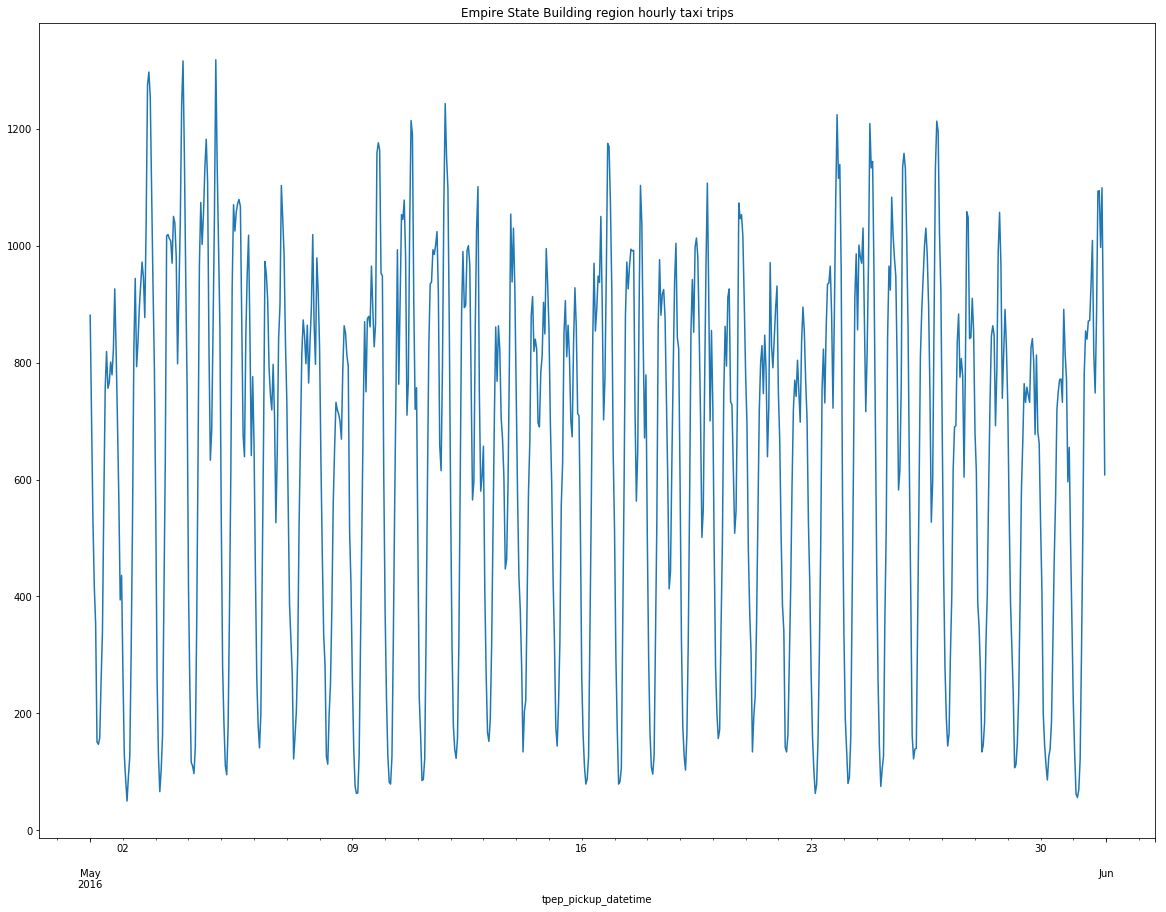

In [31]:
# plotting data for Empire State Building hourly trip count 
# Постройте график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.
df_pvt[1231].plot(figsize = (20, 15), title = 'Empire State Building region hourly taxi trips')

In [32]:
# looking on the most popular taxi regions
df_pvt.sum(axis = 0).sort_values(ascending = False).head(20)

pickup_region
1282    638799
1232    552503
1181    519623
1231    489489
1230    476106
1281    466663
1180    400463
1233    394985
1333    367654
1179    350575
1334    338480
1130    312948
1229    312521
1178    310552
1384    310246
1182    301847
1234    265118
1332    254092
1129    252281
1228    236281
dtype: int64

In [33]:
# calculating number of all unused region+hour cells
#Посчитайте, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.
print(df_pvt[df_pvt == 0].count().sum() )

1718238


In [34]:
# checking what we have the same ammount of trips in the filterred dataset and the pivoted
print(df_pvt.sum().sum() )
print(df.shape[0] )
# Great!

11626521
11626521


In [7]:
# functions for loading datasets
import numpy as np
import pandas as pd

class TripsLoader(object):
    def __new__(self):
        self.load_region(self)

    def load_region(self):
        # calculating regions
        reg = pd.read_csv('regions.csv', sep = ';')

        #borders and dividers
        self.reg_cnt = np.sqrt(reg.shape[0])
        self.lon_min = reg.west.min()
        self.lon_max = reg.east.max()
        self.lon_div = (self.lon_max - self.lon_min) / (self.reg_cnt)

        self.lat_min = reg.south.min()
        self.lat_max = reg.north.max()
        self.lat_div = (self.lat_max - self.lat_min) / (self.reg_cnt)
        return

    #cleaning MACOS zips 
    #for file in *; do   zip -d "$file" __MACOSX/\*; done

    def load_month(self, year, month, use_zip = True):
        l_file_name = 'zip/' if use_zip else 'data/'
        l_file_name += 'yellow_tripdata_' + str(year) + '-' + '%02d'%(month) + '.csv' + ('.zip' if use_zip else '')
        #loading data from zipped csv file
        l_usecols = [u'tpep_pickup_datetime', u'tpep_dropoff_datetime',
               u'passenger_count', u'trip_distance', u'pickup_longitude', u'pickup_latitude']
        l_parse_dates = [u'tpep_pickup_datetime', u'tpep_dropoff_datetime']
        l_dtype = {u'passenger_count':np.int8,
                   u'trip_distance':np.float32, u'pickup_longitude':np.float64, u'pickup_latitude':np.float64}
        df = pd.read_csv(l_file_name, compression = ('zip' if use_zip else None),
                         usecols = l_usecols,
                         dtype = l_dtype,
                         parse_dates = l_parse_dates,
                         infer_datetime_format = True
                        )

        #filtering
        df = df[(df.passenger_count > 0) &
                (df.trip_distance > 0.) &
                (df.tpep_dropoff_datetime > df.tpep_pickup_datetime) &
                (df.pickup_longitude.between(self.lon_min, self.lon_max)) &
                (df.pickup_latitude.between(self.lat_min, self.lat_max))]

        # flooring pickup datetime
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime).dt.floor('1H')


        #calculating
        df['pickup_region'] = ((df.pickup_latitude - self.lat_min) // self.lat_div + \
                           (df.pickup_longitude - self.lon_min) // self.lon_div * self.reg_cnt + 1.1).map(int)

        # dropping unnecessary columns
        df.drop(['tpep_dropoff_datetime', 'passenger_count', 'passenger_count',
             'pickup_latitude', 'pickup_longitude',
             'trip_distance'
            ], axis = 1, inplace = True)

        #grouping by datetime and region
        df['trips'] = 0
        df_grp = df.groupby([df.tpep_pickup_datetime, df.pickup_region]).count()
        df_grp = df_grp.add_suffix('_count').reset_index()

        # creating dummy dataset for good pivoting
        df0 = pd.DataFrame.from_dict(
            {'tpep_pickup_datetime': np.full((2500), np.datetime64('1900-01-01')),
             'pickup_region' : np.arange(1, 2501),
             'trips_count' : np.zeros(2500)}
        )

        df_test = pd.concat([df0, df_grp], sort = False)

        # pivoting and filtering out of dummy record
        df_pvt = pd.pivot_table(data = df_test,
                       values = 'trips_count',
                       columns = 'pickup_region',
                       index = 'tpep_pickup_datetime',
                       fill_value = 0)
        df_pvt = df_pvt[df_pvt.index > '1900-01-01']
        return df_pvt
    
    def __call__(self, *args):
        self.load_month(args)
    
    def get_coords(self):
        return self.lon_min,self.lon_max, self.lat_min, self.lat_max
    


In [36]:
%%time
# testing the function
df_pvt1 = load_month(2016, 5)

CPU times: user 45.3 s, sys: 3.49 s, total: 48.8 s
Wall time: 47.1 s


In [37]:
#checking sum
print(df_pvt1.sum().sum())

11626521


In [38]:
print(np.sum(df_pvt.memory_usage() / 1024 / 1024) )

14.19635009765625


In [44]:
%%time
# testing the function
df_pvt1 = load_month(2015, 5, False)

CPU times: user 43.8 s, sys: 3.93 s, total: 47.8 s
Wall time: 46.1 s


In [46]:
df_pvt1[1230].head()

tpep_pickup_datetime
2015-05-01 00:00:00    984
2015-05-01 01:00:00    600
2015-05-01 02:00:00    357
2015-05-01 03:00:00    218
2015-05-01 04:00:00    161
Name: 1230, dtype: int64

In [47]:
%%time
# testing the function
df_pvt1 = load_month(2016, 5)

CPU times: user 46.1 s, sys: 3.94 s, total: 50 s
Wall time: 48.5 s


In [53]:
df_pvt1.sum()[np.random.randint(0, 2500, 20)]

pickup_region
320          3
2235         0
192          0
567          0
269          1
2353         0
494          1
360          0
2396         0
697          1
2102         0
2340         0
1802         0
1285    190596
332          0
581          6
541          0
2472         4
1649        20
1795        12
dtype: int64

In [55]:
(df_pvt1.sum() == 0).sum()

1283

In [8]:
loader = TripsLoader()

In [9]:
df = loader(2016, 5)

TypeError: 'NoneType' object is not callable